# 1- Import Key Modules

In [1]:
# support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import json

# Data Preprocessing & NLP
import nltk
import re
import string
import gensim
from textblob import Word

from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
nltk.download('wordnet')
nltk.download('punkt')

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import linear_kernel

# Performance metrics
from surprise import SVD
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
sns.set()
%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hassan.sherwani\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hassan.sherwani\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 2- Load data

In [8]:
data = pd.read_csv('arxivData.csv', index_col=[0])
data.shape

(41000, 9)

In [9]:
data.head()

,author,day,id,link,month,summary,tag,title,year
0,"[{'name': 'Ahmed Osman'}, {'name': 'Wojciech S...",1,1802.00209v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",2,We propose an architecture for VQA which utili...,"[{'term': 'cs.AI', 'scheme': 'http://arxiv.org...",Dual Recurrent Attention Units for Visual Ques...,2018
1,"[{'name': 'Ji Young Lee'}, {'name': 'Franck De...",12,1603.03827v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",3,Recent approaches based on artificial neural n...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",Sequential Short-Text Classification with Recu...,2016
2,"[{'name': 'Iulian Vlad Serban'}, {'name': 'Tim...",2,1606.00776v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",6,We introduce the multiresolution recurrent neu...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",Multiresolution Recurrent Neural Networks: An ...,2016
3,"[{'name': 'Sebastian Ruder'}, {'name': 'Joachi...",23,1705.08142v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",5,Multi-task learning is motivated by the observ...,"[{'term': 'stat.ML', 'scheme': 'http://arxiv.o...",Learning what to share between loosely related...,2017
4,"[{'name': 'Iulian V. Serban'}, {'name': 'Chinn...",7,1709.02349v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",9,We present MILABOT: a deep reinforcement learn...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",A Deep Reinforcement Learning Chatbot,2017


In [11]:
from ast import literal_eval
# convert 'stringfield' lists to usable structure
features = ['author', 'link', 'tag']
for feature in features:
    data[feature] = data[feature].apply(literal_eval)

In [12]:
data.head(2)

,author,day,id,link,month,summary,tag,title,year
0,"[{'name': 'Ahmed Osman'}, {'name': 'Wojciech S...",1,1802.00209v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",2,We propose an architecture for VQA which utili...,"[{'term': 'cs.AI', 'scheme': 'http://arxiv.org...",Dual Recurrent Attention Units for Visual Ques...,2018
1,"[{'name': 'Ji Young Lee'}, {'name': 'Franck De...",12,1603.03827v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",3,Recent approaches based on artificial neural n...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",Sequential Short-Text Classification with Recu...,2016


### Data Preparing

In [13]:
def get_names(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

def get_link(x):
    for i in x:
        return i['href']
    
def get_tag(x):
    if isinstance(x, list):
        terms = [i['term'] for i in x]
        #Check if more than 5 elements exist. If yes, return only first five. If no, return entire list.
        if len(terms) > 5:
            terms = terms[:5]
        return terms

In [14]:
# list transformation
data['author'] = data['author'].apply(get_names)
data['link'] = data['link'].apply(get_link)
data['tag'] = data['tag'].apply(get_tag)

In [15]:
data.head(2)

,author,day,id,link,month,summary,tag,title,year
0,"[Ahmed Osman, Wojciech Samek]",1,1802.00209v1,http://arxiv.org/abs/1802.00209v1,2,We propose an architecture for VQA which utili...,"[cs.AI, cs.CL, cs.CV, cs.NE, stat.ML]",Dual Recurrent Attention Units for Visual Ques...,2018
1,"[Ji Young Lee, Franck Dernoncourt]",12,1603.03827v1,http://arxiv.org/abs/1603.03827v1,3,Recent approaches based on artificial neural n...,"[cs.CL, cs.AI, cs.LG, cs.NE, stat.ML]",Sequential Short-Text Classification with Recu...,2016


### Data Cleaning

In [16]:
def clean_text(text):
    # remove everything except alphabets
    text = re.sub("[^a-zA-Z]", " ", text)
    # remove whitespaces
    text = ' '.join(text.split())
    text = text.lower()
    
    return text

In [17]:
# creating clean text feature
features = ['title', 'summary']
for feature in features:
    data['clean_' + feature] = data[feature].apply(clean_text)

# 3-Visualization

In [18]:
# merging two columns in one as it will provide us more context
data['text'] = data['clean_title'] + data['clean_summary']

In [19]:
data.text[0]

'dual recurrent attention units for visual question answeringwe propose an architecture for vqa which utilizes recurrent layers to generate visual and textual attention the memory characteristic of the proposed recurrent attention units offers a rich joint embedding of visual and textual features and enables the model to reason relations between several parts of the image and question our single model outperforms the first place winner on the vqa dataset performs within margin to the current state of the art ensemble model we also experiment with replacing attention mechanisms in other state of the art models with our implementation and show increased accuracy in both cases our recurrent attention mechanism improves performance in tasks requiring sequential or relational reasoning on the vqa dataset'

In [20]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 55.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    
    freq_dist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(freq_dist.keys()), 'count':list(freq_dist.values())})
    
    fig = plt.figure(figsize=(21,16))
    ax1 = fig.add_subplot(2,1,1)
    wordcloud = WordCloud(width=1000, height=300, background_color='black', 
                          max_words=1628, relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False).generate_from_frequencies(freq_dist)
    
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    
    # select top 20 most frequent word
    ax2 = fig.add_subplot(2,1,2)
    d = words_df.nlargest(columns="count", n = terms) 
    ax2 = sns.barplot(data=d, palette = sns.color_palette('BuGn_r'), x= "count", y = "word")
    ax2.set(ylabel= 'Word')
    plt.show()

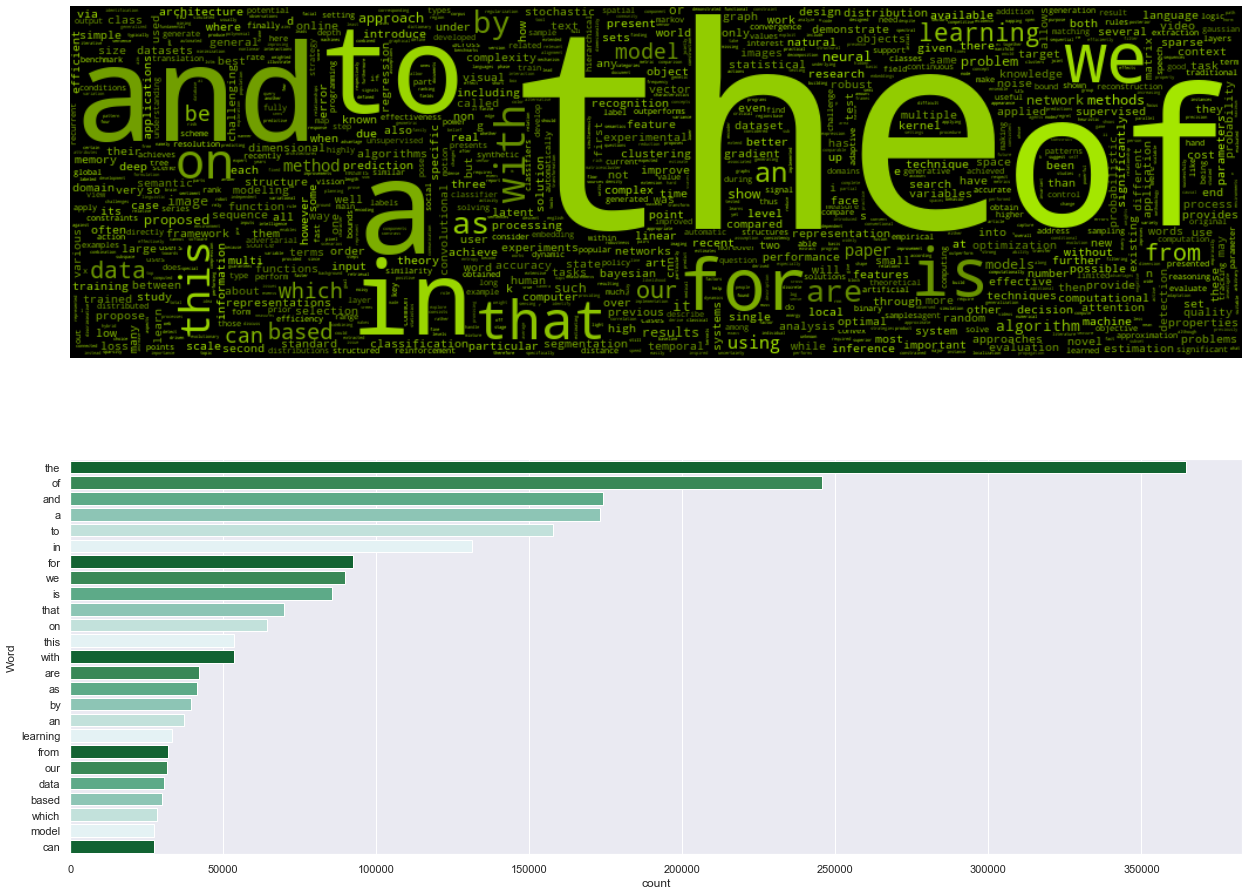

In [21]:
# plot 25 most frequent words including stop words
freq_words(data['text'], 25)

### stopwords

In [22]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)
  
data['text'] = data['text'].apply(lambda x: remove_stopwords(x))

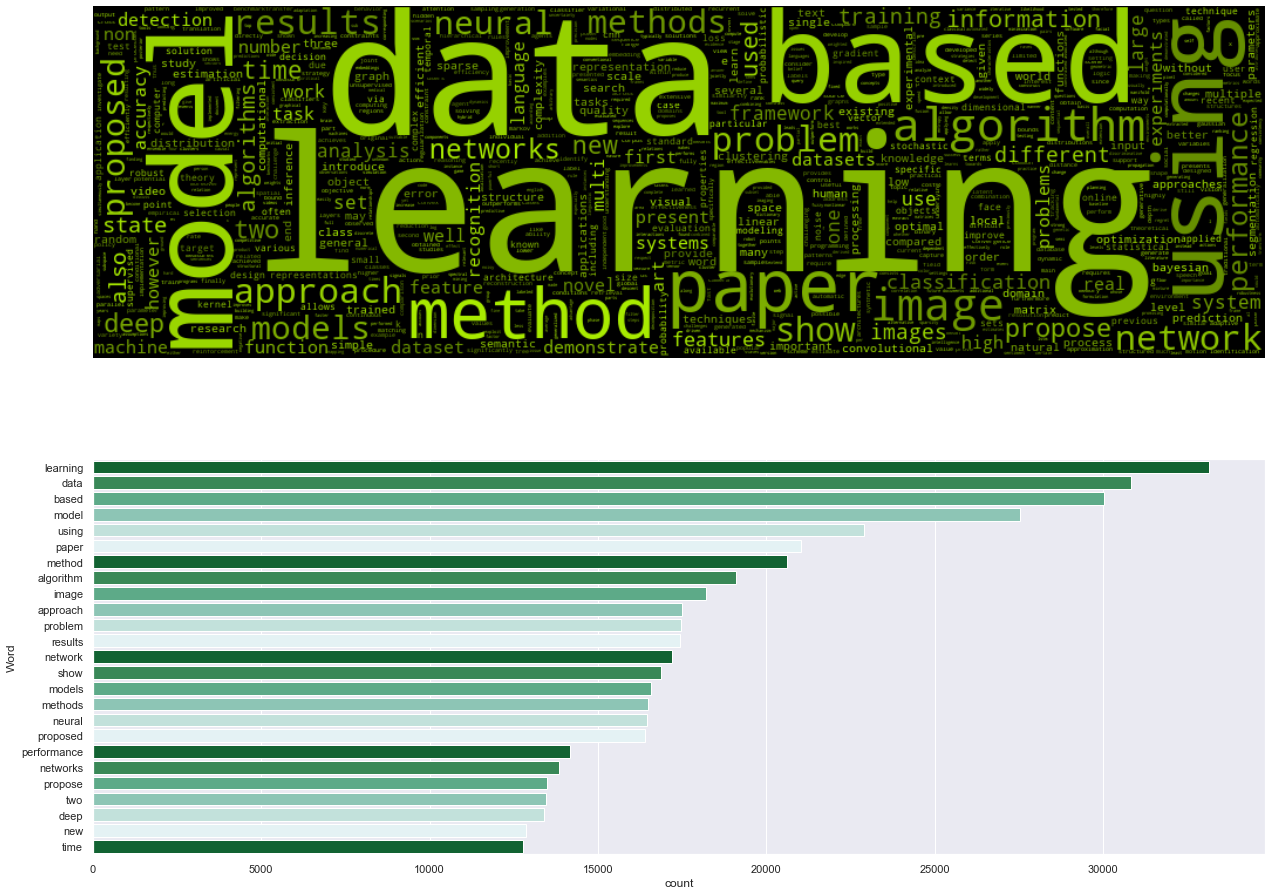

In [23]:
freq_words(data['text'], 25)

### exploring 'tag' feature

In [24]:
# get all genre tags in a list
all_tags = sum(data['tag'],[])
len(set(all_tags))

2167

In [25]:
all_tags = nltk.FreqDist(all_tags)
all_tags_df = pd.DataFrame({'Tag': list(all_tags.keys()), 'Count': list(all_tags.values())})

In [26]:
sorted_tags = all_tags_df.sort_values(by='Count', ascending=False)
sorted_tags.head(7)

,Tag,Count
2,cs.CV,13902
5,cs.LG,13734
0,cs.AI,10481
4,stat.ML,10241
1,cs.CL,6417
3,cs.NE,3817
21,cs.IR,1443


In [27]:
data[['tag', 'year']].head()

,tag,year
0,"[cs.AI, cs.CL, cs.CV, cs.NE, stat.ML]",2018
1,"[cs.CL, cs.AI, cs.LG, cs.NE, stat.ML]",2016
2,"[cs.CL, cs.AI, cs.LG, cs.NE, stat.ML]",2016
3,"[stat.ML, cs.AI, cs.CL, cs.LG, cs.NE]",2017
4,"[cs.CL, cs.AI, cs.LG, cs.NE, stat.ML]",2017


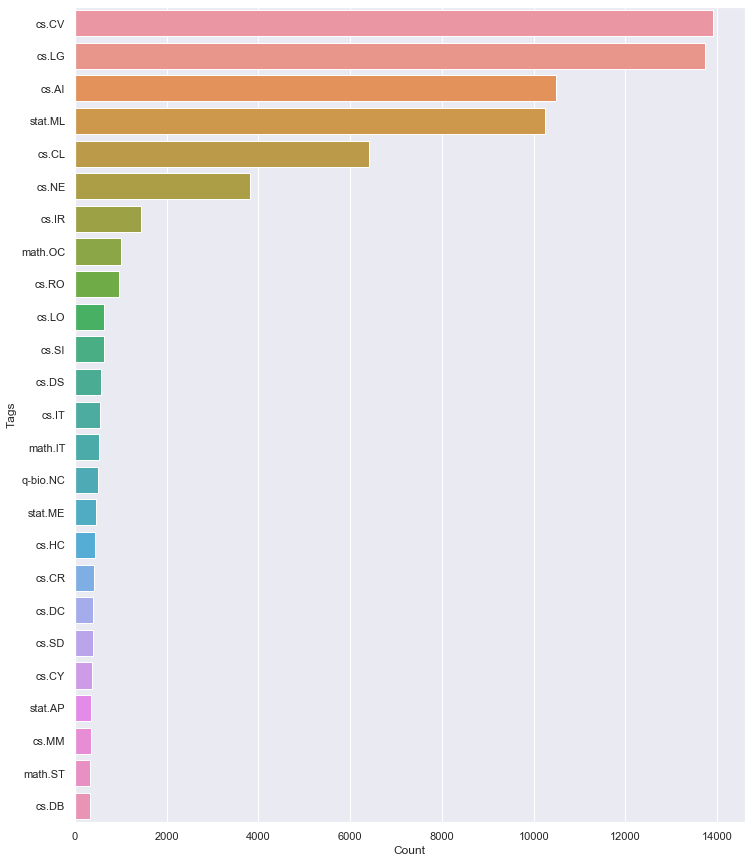

In [28]:
g = all_tags_df.nlargest(columns="Count", n = 25) 
plt.figure(figsize=(12,15))
ax = sns.barplot(data=g, x= "Count", y = "Tag")
ax.set(ylabel = 'Tags')
plt.show()

### word cloud for tag

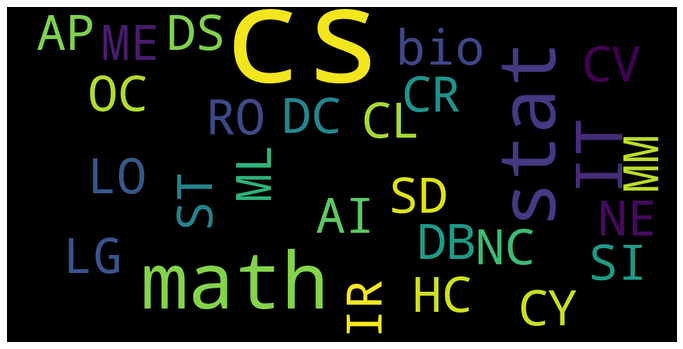

In [29]:
text = " ".join(review for review in g.Tag)
wordcloud = WordCloud(width=1000, height=500,max_font_size=200).generate(text)

plt.figure(figsize = (12, 10))
plt.imshow(wordcloud, interpolation='lanczos')
plt.axis("off")
plt.show()

### word cloud for cleaned title

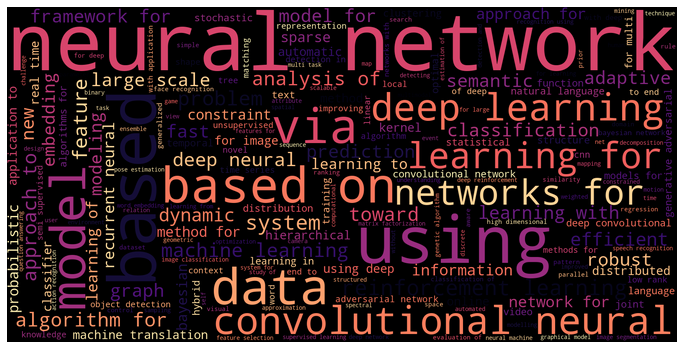

In [31]:
text = " ".join(review for review in data.clean_title)
wordcloud = WordCloud(width=1600, height=800,max_font_size=200, colormap='magma').generate(text)

plt.figure(figsize = (12, 10))
plt.imshow(wordcloud, interpolation='spline36')
plt.axis("off")
plt.show()

### word cloud for cleaned summary

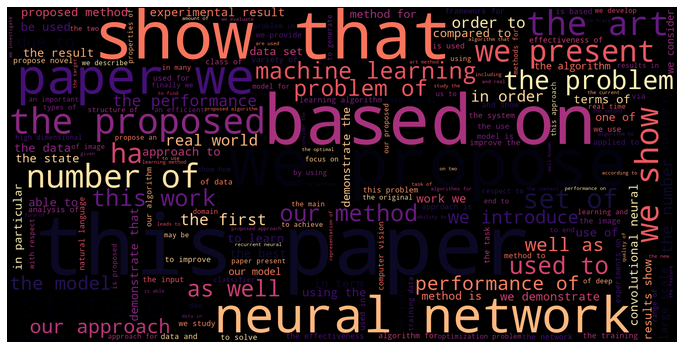

In [33]:
text = " ".join(review for review in data.clean_summary)
wordcloud = WordCloud(width=1600, height=800,max_font_size=200, colormap='magma').generate(text)

plt.figure(figsize = (12, 10))
plt.imshow(wordcloud, interpolation='spline36')
plt.axis("off")
plt.show()

# 4- Pre-Model Preparation

### 4.1.lemmatizer

In [34]:
# Lemmatization process
'''
Words in the third person are changed to first person and verbs in past and future tenses are changed into the present by the 
lemmatization process. 
'''
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    # tokenization to ensure that punctuation is caught as its own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    lem = [lemmatizer.lemmatize(t) for t in filtered_tokens]
    return lem

### 4.2.BOW vectorizer

In [35]:
# Defining a Count Vectorizer object
count_vec = CountVectorizer(stop_words='english', max_features=10000)

### 4.3.tf-idf vectorizer

In [36]:
# Defining a TF-IDF Vectorizer
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), tokenizer=tokenize_and_lemmatize, max_features=10000, use_idf=True)

### 4.4. train test split

In [37]:
mb = MultiLabelBinarizer()
mb.fit(data['tag'])

y = mb.transform(data['tag'])

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['text'], y, test_size=0.2, random_state=55)

In [40]:
# Count Vectorizer transformation
xtrain_cv = count_vec.fit_transform(X_train)
xtest_cv = count_vec.transform(X_test)

In [41]:
print(xtrain_cv.shape)
print(xtest_cv.shape)

(32800, 10000)
(8200, 10000)


In [42]:
# Tf-Idf transformation 
xtrain_tfidf = tfidf_vec.fit_transform(X_train)
xtest_tfidf = tfidf_vec.transform(X_test)
print(xtrain_tfidf.shape)
print(xtest_tfidf.shape)

(32800, 10000)
(8200, 10000)


In [43]:
# to hold model's results
evaluation_list=[]

# 5- Classification Models

### 5.1.Logistic Regression

In [44]:
log_reg = LogisticRegression()
oneVsRest = OneVsRestClassifier(log_reg)
oneVsRest.fit(xtrain_tfidf, y_train)

OneVsRestClassifier(estimator=LogisticRegression())

In [45]:
y_pred = oneVsRest.predict(xtest_tfidf)

def get_performance(y_test, y_pred):
    # Evaluate Performance
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    # Get precision, recall, f1 scores
    precision, recall, f1score, support = score(y_test, y_pred, average='micro')
    return accuracy, precision, recall, f1score

# Performance metrics
accuracy, precision, recall, f1score = get_performance(y_test, y_pred)
print(f'Test Accuracy Score of Basic Logistic Reg.: % {accuracy}')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1score}')

Test Accuracy Score of Basic Logistic Reg.: % 36.4
Precision : 0.8239295718287315
Recall    : 0.5110449242988334
F1-score   : 0.6308210784313725


In [46]:
# Add performance parameters to list
evaluation_list.append(dict([
    ('Model', 'Logistic Regression'),
    ('Test Accuracy', round(accuracy, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1score, 2))
     ]))

In [47]:
mb.inverse_transform(y_pred)[16]

('cs.CV',)

### 5.2.Multinomial Naive Bayes

In [48]:
nbayes = MultinomialNB()
oneVsRest_nb = OneVsRestClassifier(nbayes)
oneVsRest_nb.fit(xtrain_tfidf, y_train)

OneVsRestClassifier(estimator=MultinomialNB())

In [49]:
y_pred = oneVsRest_nb.predict(xtest_tfidf)

# Performance metrics
accuracy, precision, recall, f1score = get_performance(y_test, y_pred)
print(f'Test Accuracy Score of Basic Logistic Reg.: % {accuracy}')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1score}')

Test Accuracy Score of Basic Logistic Reg.: % 34.91
Precision : 0.7980252224068823
Recall    : 0.5065152643335815
F1-score   : 0.6197001328525337


In [50]:
# Add performance parameters to list
evaluation_list.append(dict([
    ('Model', 'MultinomialNB'),
    ('Test Accuracy', round(accuracy, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1score, 2))
     ]))

In [51]:
mb.inverse_transform(y_pred)[16]

('cs.CV',)

### 5.3.Linear SVC

In [52]:
linear_svc = LinearSVC()
oneVsRest_svc = OneVsRestClassifier(linear_svc)
oneVsRest_svc.fit(xtrain_tfidf, y_train)

OneVsRestClassifier(estimator=LinearSVC())

In [53]:
y_pred = oneVsRest_svc.predict(xtest_tfidf)

# Performance metrics
accuracy, precision, recall, f1score = get_performance(y_test, y_pred)
print(f'Test Accuracy Score of Basic Logistic Reg.: % {accuracy}')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1score}')

Test Accuracy Score of Basic Logistic Reg.: % 35.34
Precision : 0.7721739130434783
Recall    : 0.5510052122114668
F1-score   : 0.6431054461181922


In [54]:
# Add performance parameters to list
evaluation_list.append(dict([
    ('Model', 'LinearSVC'),
    ('Test Accuracy', round(accuracy, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1score, 2))
     ]))

In [55]:
mb.inverse_transform(y_pred)[16]

('cs.CV',)

### 5.4.Random Forest

In [ ]:
rforest = RandomForestClassifier(n_estimators=100)
oneVsRest_rf = OneVsRestClassifier(rforest)
oneVsRest_rf.fit(xtrain_tfidf, y_train)

In [ ]:
y_pred = oneVsRest_rf.predict(xtest_tfidf)

# Performance metrics
accuracy, precision, recall, f1score = get_performance(y_test, y_pred)
print(f'Test Accuracy Score of Basic Logistic Reg.: % {accuracy}')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1score}')

In [ ]:
# Add performance parameters to list
evaluation_list.append(dict([
    ('Model', 'RandomForestClassifier'),
    ('Test Accuracy', round(accuracy, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1score, 2))
     ]))

### 5.5.Performance metrics of models

In [ ]:
results = pd.DataFrame(data=evaluation_list)
results = results[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
results = results.sort_values(by='Test Accuracy', ascending=False)
results = results.set_index('Model')
results

# 6- Model Tune: GridSearch

In [ ]:
param = {'estimator__penalty':['l1', 'l2'], 'estimator__C':[0.001, 0.01, 1, 10]}

In [ ]:
oneVsRest.get_params().keys()

In [ ]:
# GridSearchCV
kf=KFold(n_splits=10, shuffle=True, random_state=55)
lr_grid = GridSearchCV(oneVsRest, param_grid = param, cv = kf, scoring='f1_micro', n_jobs=-1)
lr_grid.fit(xtrain_tfidf, y_train)

In [ ]:
# examine the best model
print(lr_grid.best_score_)
print(lr_grid.best_params_)
print(lr_grid.best_estimator_)

In [ ]:
# Optimized Logistic Regression Model
log_reg = LogisticRegression(C=10, penalty='l2')
ovr = OneVsRestClassifier(log_reg)
ovr.fit(xtrain_tfidf, y_train)

In [ ]:
# performance metrics of the optimized model
y_pred = ovr.predict(xtest_tfidf)

accuracy, precision, recall, f1score = get_performance(y_test, y_pred)
print(f'Test Accuracy Score of Basic Logistic Reg.: % {accuracy}')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1score}')

In [ ]:
# Inference funct to handle new data that will come in the future
def infer_tags(text):
    text = clean_text(text)
    text = remove_stopwords(text)
    text_vec = tfidf_vec.transform([text])
    y_pred = ovr.predict(text_vec)
    return mb.inverse_transform(y_pred)

In [ ]:
for i in range(10):
    sp = X_test.sample(1).index[0]
    print("Title: ", data['title'][sp], "\nPredicted tag: ", infer_tags(X_test[sp])), print("Actual tag: ",data['tag'][sp], "\n")

# 7-Article Recommendation Engine

### 7.a.Recommender based on summary

In [ ]:
data['clean_summary'].head()

In [ ]:
# TfIdf matrix transformation on clean_summary column
tfidf_matrix = tfidf_vec.fit_transform(data['clean_summary'])
# Compute the cosine similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
indices = pd.Series(data.index, index=data['title']).drop_duplicates()

In [ ]:

def get_recommendations(title, similarity):
    
    idx = indices[title]
    # pairwsie similarity scores
    sim_scores = list(enumerate(similarity[idx]))
    # sorting
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]

    article_indices = [i[0] for i in sim_scores]
    # Return the top 10 most related articles
    return data[['link', 'title']].iloc[article_indices]

In [ ]:
get_recommendations('Towards Bayesian Deep Learning: A Survey', cosine_sim)

### 7.b.Recommender based on tags, author, and title

In [ ]:
# convert all strings to lower case & strip names of spaces
def clean_lists(text):
    if isinstance(text, list):
        return [str.lower(i.replace(" ", "")) for i in text]
    else:
        if isinstance(text, str):
            return str.lower(text.replace(" ", ""))
        else:
            return ''

features = ['tag', 'author']
for feature in features:
    arxivData[feature] = arxivData[feature].apply(clean_lists)

In [ ]:
# create soup to vectorization process
def create_text(text):
    return ' '.join(text['tag']) + ' ' + ' '.join(text['author']) + ' ' + ' '.join(text['title'])

data['text2'] = data.apply(create_text, axis=1)

In [ ]:
# CountVectorizer object's defined at the beginning of Part 3-text mining alg. section
count_matrix = count_vec.fit_transform(arxivData['soup2']) 
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [ ]:
get_recommendations('Towards Bayesian Deep Learning: A Survey', cosine_sim2)

In [ ]:
get_recommendations('A Deep Reinforcement Learning Chatbot', cosine_sim2)